Библиотеки

In [19]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

Ф-я для нормального отображения цветов

In [28]:
def plot_img(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Загрузка весов

In [21]:
weights_version = "13_04_2024"

weights = "detector"
# weights = "segmentator"

In [22]:
model = YOLO(f"weights_{weights_version}/{weights}.pt")

Загрузка исходной фотки

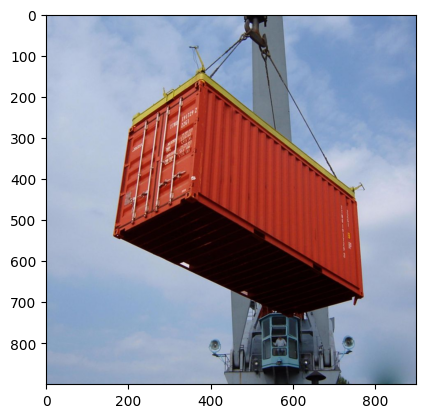

In [29]:
source = cv2.imread("img2.jpeg")

plot_img(source)

Ищем контейнеры

In [24]:
results = model(source, save=True, iou=0.5)


0: 640x640 1 Shipping container, 748.9ms
Speed: 4.5ms preprocess, 748.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict11


Смотрим ч у нас в боксе

In [25]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8915])
data: tensor([[157.4359, 152.8777, 773.5736, 758.9641,   0.8915,   0.0000]])
id: None
is_track: False
orig_shape: (900, 900)
shape: torch.Size([1, 6])
xywh: tensor([[465.5048, 455.9209, 616.1377, 606.0864]])
xywhn: tensor([[0.5172, 0.5066, 0.6846, 0.6734]])
xyxy: tensor([[157.4359, 152.8777, 773.5736, 758.9641]])
xyxyn: tensor([[0.1749, 0.1699, 0.8595, 0.8433]])

Обрезаем фотку

In [32]:
top_left = (np.array(results[0].boxes.xyxy[0, :2], dtype=int))
bottom_right = (np.array(results[0].boxes.xyxy[0, 2:],  dtype=int))
cropped_img = source[0:bottom_right[1], top_left[0]:bottom_right[0]]

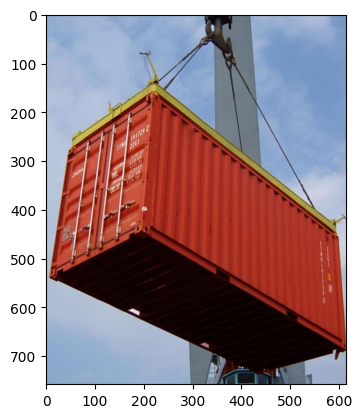

True

In [42]:
plot_img(cropped_img)
name_of_cropped_file = "cropped_img.jpg"
cv2.imwrite("cropped_img.jpg", cropped_img)

Ищем прямые на картинке 

In [44]:
import kornia as K
import kornia.feature as KF
import torch

In [45]:
torch_img1 = K.io.load_image(name_of_cropped_file, K.io.ImageLoadType.RGB32)[None, ...]
cropped_img.shape

(758, 616, 3)

In [46]:
# First, convert the images to gray scale
torch_img1_gray = K.color.rgb_to_grayscale(torch_img1)

In [49]:
sold2 = KF.SOLD2(pretrained=True, config=None)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/sold2_wireframe.pth" to /Users/lnrsmglln/.cache/torch/hub/checkpoints/sold2_wireframe.pth
100%|██████████| 140M/140M [17:31<00:00, 139kB/s]    


In [51]:
%%capture
with torch.inference_mode():
    outputs = sold2(torch_img1_gray)

In [52]:
outputs

{'junction_heatmap': tensor([[[4.7838e-04, 9.0504e-05, 5.9929e-05,  ..., 8.5766e-06, 1.5295e-05, 6.1764e-05],
          [7.9415e-05, 8.5226e-06, 2.3926e-06,  ..., 2.5106e-07, 8.3699e-07, 7.2447e-06],
          [5.3576e-05, 2.9042e-06, 9.7062e-07,  ..., 1.1569e-07, 2.4656e-07, 2.5405e-06],
          ...,
          [9.6184e-04, 5.5634e-05, 7.7239e-05,  ..., 7.6412e-05, 1.7359e-04, 1.1810e-03],
          [3.8087e-04, 1.5718e-05, 2.1679e-05,  ..., 5.3965e-05, 7.1634e-05, 6.0813e-04],
          [4.1575e-04, 1.1061e-05, 8.1889e-06,  ..., 2.1550e-05, 3.7735e-05, 1.7128e-04]]]),
 'line_heatmap': tensor([[[1.8382e-03, 9.6134e-04, 4.5801e-04,  ..., 1.8508e-04, 5.4310e-04, 1.2921e-03],
          [9.2472e-04, 4.5590e-04, 2.0410e-04,  ..., 5.9530e-05, 1.8874e-04, 5.7619e-04],
          [5.3774e-04, 2.6608e-04, 7.9273e-05,  ..., 1.7266e-05, 5.8302e-05, 1.8878e-04],
          ...,
          [2.4815e-04, 1.6064e-04, 9.8503e-05,  ..., 1.1720e-04, 3.0616e-04, 6.1550e-04],
          [5.0803e-04, 2.3195e-

In [55]:
line_seg = outputs["line_segments"][0]
desc = outputs["dense_desc"][0]

тут идет отрисовка двух картинок как в примере, переделывать лень

In [56]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

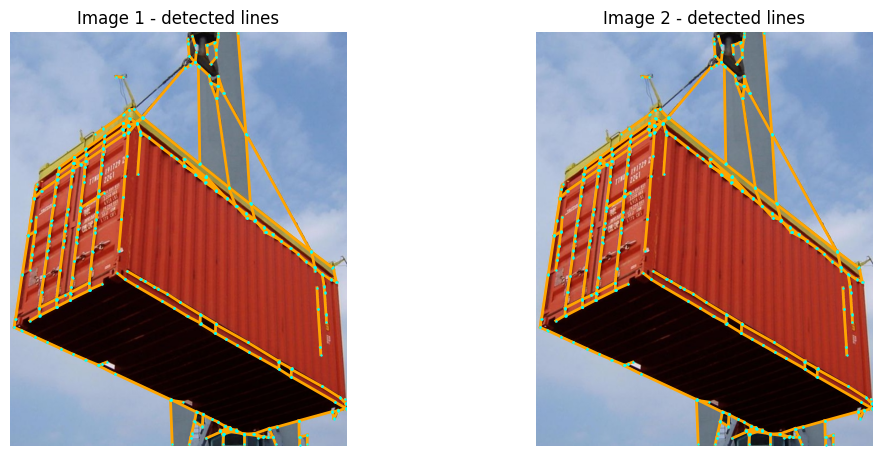

In [58]:
imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img1)]
lines_to_plot = [line_seg.numpy(), line_seg.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})